<a href="https://colab.research.google.com/github/gauravksingh16/FundusImage_QualityAssesment/blob/main/EyeQ_Assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf sample_data

In [ ]:
import pandas as pd
from google.colab import drive

In [ ]:
!rm -rf "/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/Preprocessed Images/"

In [ ]:
import os
import pandas as pd

# Path to the folder containing images
folder_path = '/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/'

# List to store data
data = {'filename': [], 'quality': []}

# Loop through the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):  # Adjust file extensions as needed
        if 'good' in filename:
            data['filename'].append(filename)
            data['quality'].append(0)
        elif 'bad' in filename:
            data['filename'].append(filename)
            data['quality'].append(1)

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_path = '/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/EyeQ_info.csv'
df.to_csv(csv_path, index=False)

# Display the DataFrame
df.head(20)


,filename,quality
0,drimdb_bad (1).jpg,1
1,drimdb_bad (3).jpg,1
2,drimdb_bad (2).jpg,1
3,drimdb_bad (4).jpg,1
4,drimdb_bad (11).jpg,1
5,drimdb_bad (18).jpg,1
6,drimdb_good (2).jpg,0
7,drimdb_good (3).jpg,0
8,drimdb_good (4).jpg,0
9,drimdb_good (6).jpg,0


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import numpy as np
import cv2
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from typing import List, Tuple
from PIL import ImageFile
from google.colab.patches import cv2_imshow
import csv

In [ ]:
def imread(file_path: str, c: int = None) -> np.ndarray:
    if c is None:
        im = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    else:
        im = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), c)

    if im is None:
        raise Exception('Cannot read image')

    if im.ndim == 3 and im.shape[2] == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

def imwrite(file_path: str, image: np.ndarray) -> None:
    if image is None or image.size == 0:
        print("Image is empty or None. Skipping image write.")
        return

    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif image.dtype == np.bool_:
        image = (image * 255).astype(np.uint8)

    cv2.imwrite(file_path, image)

def fold_dir(folder: str) -> str:
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder

def get_mask_BZ(img: np.ndarray) -> np.ndarray:
    if img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    threshold = np.mean(gray_img) / 3 - 5
    _, mask = cv2.threshold(gray_img, max(5, threshold), 1, cv2.THRESH_BINARY)

    nn_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), np.uint8)
    new_mask = (1 - mask).astype(np.uint8)
    _, new_mask, _, _ = cv2.floodFill(new_mask, nn_mask, (0, 0), (0), cv2.FLOODFILL_MASK_ONLY)
    _, new_mask, _, _ = cv2.floodFill(new_mask, nn_mask, (new_mask.shape[1] - 1, new_mask.shape[0] - 1), (0), cv2.FLOODFILL_MASK_ONLY)
    mask = mask + new_mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,  20))
    mask = cv2.erode(mask, kernel)
    mask = cv2.dilate(mask, kernel)
    return mask

def _get_center_by_edge(mask: np.ndarray) -> List[int]:
    center = [0, 0]
    x = mask.sum(axis=1)
    center[0] = np.where(x > x.max() * 0.95)[0].mean()
    x = mask.sum(axis=0)
    center[1] = np.where(x > x.max() * 0.95)[0].mean()
    return center

def _get_radius_by_mask_center(mask: np.ndarray, center: List[int]) -> int:
    mask = mask.astype(np.uint8)
    ksize = max(mask.shape[1] // 400 * 2 + 1, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    mask = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)

    index = np.where(mask > 0)
    d_int = np.sqrt((index[0] - center[0]) ** 2 + (index[1] - center[1]) ** 2)
    b_count = np.bincount(np.ceil(d_int).astype(int))
    # Check if b_count is empty
    if not b_count.any():
        radius = 0  # Set a default radius
    else:
        radius = int(np.where(b_count > b_count.max() * 0.995)[0].max())
    return radius

    return radius

def _get_circle_by_center_bbox(shape: Tuple[int, int], center: List[int], bbox: Tuple[int, int, int, int], radius: int) -> np.ndarray:
    center_mask = np.zeros(shape=shape).astype('uint8')
    tmp_mask = np.zeros(shape=bbox[2:4])
    center_tmp = (int(center[0]), int(center[1]))
    center_mask = cv2.circle(center_mask, center_tmp[::-1], int(radius), (1), -1)
    return center_mask

def get_mask(img: np.ndarray) -> Tuple[np.ndarray, Tuple[int, int, int, int], List[int], int]:
    if img.ndim == 3:
        g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img.ndim == 2:
        g_img = img.copy()
    else:
        raise Exception('Image dimension is not 1 or 3')

    h, w = g_img.shape
    shape = g_img.shape[0:2]
    tg_img = cv2.normalize(g_img, None, 0, 255, cv2.NORM_MINMAX)
    tmp_mask = get_mask_BZ(tg_img)
    center = _get_center_by_edge(tmp_mask)
    radius = _get_radius_by_mask_center(tmp_mask, center)

    center = [center[0], center[1]]
    radius = int(radius)
    s_h = max(0, int(center[0] - radius))
    s_w = max(0, int(center[1] - radius))
    bbox = (s_h, s_w, min(h - s_h, 2 * radius), min(w - s_w, 2 * radius))
    tmp_mask = _get_circle_by_center_bbox(shape, center, bbox, radius)
    return tmp_mask, bbox, center, radius

def mask_image(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    img[mask <= 0, ...] = 0
    return img

def remove_back_area(img: np.ndarray, bbox: Tuple[int, int, int, int] = None, border: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    image = img
    if border is None:
        border = np.array((bbox[0], bbox[0] + bbox[2], bbox[1], bbox[1] + bbox[3], img.shape[0], img.shape[1]), dtype=int)
    image = image[border[0]:border[1], border[2]:border[3], ...]
    return image, border

def supplemental_black_area(img: np.ndarray, border: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    image = img
    if border is None:
        h, v = img.shape[0:2]
        max_l = max(h, v)
        if image.ndim > 2:
            image = np.zeros(shape=[max_l, max_l, img.shape[2]], dtype=int)
        else:
            image = np.zeros(shape=[max_l, max_l], dtype=int)
        border = (int(max_l / 2 - h / 2), int(max_l / 2 - h / 2) + h, int(max_l / 2 - v / 2), int(max_l / 2 - v / 2) + v, max_l)
    else:
        max_l = border[4]
        if image.ndim > 2:
            image = np.zeros(shape=[max_l, max_l, img.shape[2]], dtype=img.dtype)
        else:
            image = np.zeros(shape=[max_l, max_l], dtype=img.dtype)
    image[border[0]:border[1], border[2]:border[3], ...] = img
    return image, border

def process_without_gb(img: np.ndarray, label: np.ndarray, radius_list: List[int],
                       centre_list_w: List[int], centre_list_h: List[int]) -> Tuple[np.ndarray, List, np.ndarray, np.ndarray, List[int], List[int], List[int]]:
    borders = []
    mask, bbox, center, radius = get_mask(img)
    r_img = mask_image(img, mask)
    r_img, r_border = remove_back_area(r_img, bbox=bbox)
    mask, _ = remove_back_area(mask, border=r_border)
    label, _ = remove_back_area(label, bbox=bbox)
    borders.append(r_border)
    r_img, sup_border = supplemental_black_area(r_img)
    label, sup_border = supplemental_black_area(label)
    mask, _ = supplemental_black_area(mask, border=sup_border)
    borders.append(sup_border)

    radius_list.append(radius)
    centre_list_w.append(int(center[0]))
    centre_list_h.append(int(center[1]))

    return r_img, borders, (mask * 255).astype(np.uint8), label, radius_list, centre_list_w, centre_list_h

In [ ]:
# Set your training and preprocessed image folders
training_folder = "/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/"
preprocessed_folder = "/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/Preprocessed Images/"

# Ensure the preprocessed folder exists
os.makedirs(preprocessed_folder, exist_ok=True)

# Iterate through each image in the training folder
for filename in os.listdir(training_folder):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):  # Update the file extensions if needed
        img_path = os.path.join(training_folder, filename)
        label_path = img_path  # Update this based on your label image paths

        img = imread(img_path)
        label = imread(label_path)

        # Initialize lists for each image
        radius_list = []
        centre_list_w = []
        centre_list_h = []
        name_list = []

        # Process the image
        result_img, borders, mask, processed_label, radius_list, centre_list_w, centre_list_h = process_without_gb(img, label, radius_list, centre_list_w, centre_list_h)


        # Save preprocessed image
        preprocessed_img_path = os.path.join(preprocessed_folder, filename)
        result_img = result_img.astype(np.uint8)
        imwrite(preprocessed_img_path, result_img)

        # Print a success message
        print("Image successfully written to:", preprocessed_img_path)

In [ ]:
# Define constants
img_size = (224, 224)
batch_size = 32

In [ ]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, folder_path, transform=None):
        self.dataframe = dataframe
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        # Change the image name in __getitem__ to be a valid file path
        image = Image.open(os.path.join(self.folder_path, self.dataframe.iloc[idx, 0]))

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load your CSV file containing filenames and quality labels
csv_path = '/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/EyeQ_info.csv'
df = pd.read_csv(csv_path)

In [ ]:
# Define data transformations with augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

In [ ]:
# Split the dataset into training, validation, and test sets using scikit-learn
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
# Create data loaders for training, validation, and test sets
train_dataset = CustomDataset(dataframe=train_df, folder_path='/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/Preprocessed Images', transform=train_transform)
val_dataset = CustomDataset(dataframe=val_df, folder_path='/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/Preprocessed Images', transform=test_transform)
test_dataset = CustomDataset(dataframe=test_df, folder_path='/content/drive/MyDrive/EyeDataset/EyeQ_Dataset/Preprocessed Images', transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load pre-trained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to fit your binary classification task
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 1)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Training the model with data augmentation
num_epochs = 10
for epoch in range(num_epochs):
    resnet_model.train()
    for images, labels in train_loader:
        images, labels = Variable(images), Variable(labels.float())
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    resnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = Variable(images), Variable(labels.float())
            outputs = resnet_model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            val_loss += criterion(outputs, labels.unsqueeze(1)).item()

    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
resnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = Variable(images), Variable(labels.float())
        outputs = resnet_model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10, Loss: 2.1727, Val Loss: 0.5835, Val Accuracy: 81.25%
Epoch 2/10, Loss: 0.0848, Val Loss: 1.0252, Val Accuracy: 68.75%
Epoch 3/10, Loss: 0.1100, Val Loss: 0.3118, Val Accuracy: 93.75%
Epoch 4/10, Loss: 0.7882, Val Loss: 0.2386, Val Accuracy: 84.38%
Epoch 5/10, Loss: 0.6183, Val Loss: 0.0874, Val Accuracy: 100.00%
Epoch 6/10, Loss: 0.2712, Val Loss: 0.2812, Val Accuracy: 90.62%
Epoch 7/10, Loss: 0.3073, Val Loss: 0.0789, Val Accuracy: 96.88%
Epoch 8/10, Loss: 0.2024, Val Loss: 0.0369, Val Accuracy: 100.00%
Epoch 9/10, Loss: 0.1099, Val Loss: 0.0435, Val Accuracy: 100.00%
Epoch 10/10, Loss: 0.1485, Val Loss: 0.0442, Val Accuracy: 96.88%
Test Accuracy: 100.00%


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.5077, Val Loss: 0.4770, Val Accuracy: 65.62%
Epoch 2/10, Loss: 0.0556, Val Loss: 0.1315, Val Accuracy: 96.88%
Epoch 3/10, Loss: 0.3606, Val Loss: 0.2592, Val Accuracy: 93.75%
Epoch 4/10, Loss: 0.0829, Val Loss: 6.0471, Val Accuracy: 46.88%
Epoch 5/10, Loss: 0.0817, Val Loss: 0.0553, Val Accuracy: 96.88%
Epoch 6/10, Loss: 0.0093, Val Loss: 0.0609, Val Accuracy: 96.88%
Epoch 7/10, Loss: 0.1530, Val Loss: 0.0133, Val Accuracy: 100.00%
Epoch 8/10, Loss: 0.1734, Val Loss: 0.0257, Val Accuracy: 96.88%
Epoch 9/10, Loss: 0.0399, Val Loss: 0.0401, Val Accuracy: 100.00%
Epoch 10/10, Loss: 0.0130, Val Loss: 0.0242, Val Accuracy: 100.00%


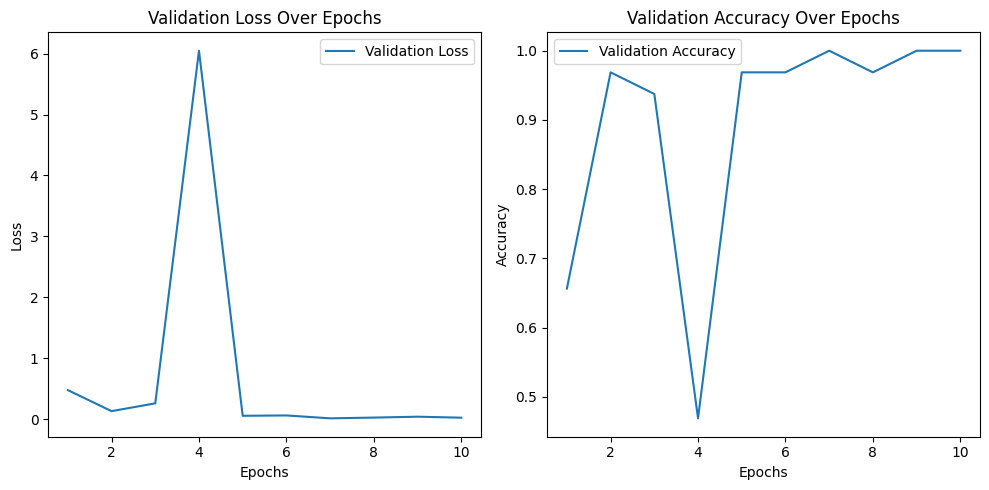

Simple Accuracy: 97.50%
Test Accuracy: 97.50%
Precision: 0.9375
Recall: 1.0000
F1 Score: 0.9677
ROC AUC Score: 0.9800


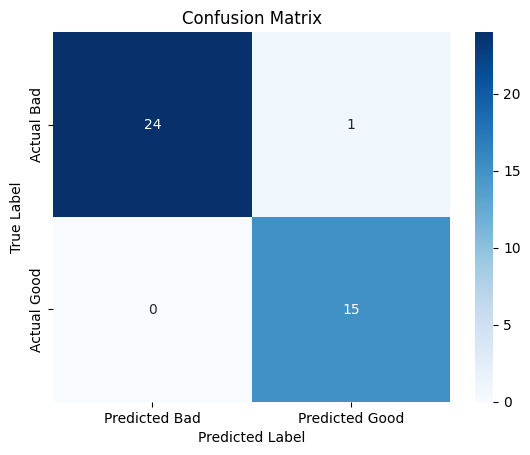

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Load pre-trained ResNet model
resnet_model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to fit your binary classification task
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 1)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Initialize lists to store validation losses and accuracies
val_losses = []
val_accuracies = []

# Training the model with data augmentation
num_epochs = 10
for epoch in range(num_epochs):
    resnet_model.train()
    for images, labels in train_loader:
        images, labels = Variable(images), Variable(labels.float())
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    resnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    ground_truth = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = Variable(images), Variable(labels.float())
            outputs = resnet_model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            val_loss += criterion(outputs, labels.unsqueeze(1)).item()

            # Collect predictions and ground truth for metrics
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    # Calculate and store validation accuracy
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Plotting the validation loss and accuracy over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), val_losses[:num_epochs], label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
resnet_model.eval()
correct = 0
total = 0
# Calculate predictions on the test set
test_predictions = []
test_ground_truth = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = Variable(images), Variable(labels.float())
        outputs = resnet_model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

        # Collect predictions and ground truth for the confusion matrix
        test_predictions.extend(predicted.cpu().numpy())
        test_ground_truth.extend(labels.cpu().numpy())

# Calculate additional metrics on the test set
simple_accuracy = correct / total
accuracy = accuracy_score(test_ground_truth, test_predictions)
precision = precision_score(test_ground_truth, test_predictions)
recall = recall_score(test_ground_truth, test_predictions)
f1 = f1_score(test_ground_truth, test_predictions)
roc_auc = roc_auc_score(test_ground_truth, test_predictions)

# Print metrics
print(f'Simple Accuracy: {simple_accuracy * 100:.2f}%')
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')


# Calculate confusion matrix
cm = confusion_matrix(test_ground_truth, test_predictions)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Bad', 'Predicted Good'], yticklabels=['Actual Bad', 'Actual Good'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
torch.save(resnet_model, '/content/drive/MyDrive/EyeDataset/EyeQ_resnet_model.pth')

In [ ]:
# Load pre-trained DenseNet model
densenet_model = models.densenet121(pretrained=True)

# Modify the final fully connected layer to fit your binary classification task
num_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_features, 1)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=0.001)

# Training the model with data augmentation
num_epochs = 10
for epoch in range(num_epochs):
    densenet_model.train()
    for images, labels in train_loader:
        images, labels = Variable(images), Variable(labels.float())
        optimizer.zero_grad()
        outputs = densenet_model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    densenet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = Variable(images), Variable(labels.float())
            outputs = densenet_model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            val_loss += criterion(outputs, labels.unsqueeze(1)).item()

    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
densenet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = Variable(images), Variable(labels.float())
        outputs = densenet_model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 42.6MB/s]


Epoch 1/10, Loss: 0.1212, Val Loss: 0.2910, Val Accuracy: 90.62%
Epoch 2/10, Loss: 0.1323, Val Loss: 0.1643, Val Accuracy: 93.75%
Epoch 3/10, Loss: 0.1672, Val Loss: 0.5413, Val Accuracy: 84.38%
Epoch 4/10, Loss: 0.1200, Val Loss: 0.0764, Val Accuracy: 96.88%
Epoch 5/10, Loss: 0.2222, Val Loss: 0.1788, Val Accuracy: 93.75%
Epoch 6/10, Loss: 0.0629, Val Loss: 0.0326, Val Accuracy: 96.88%
Epoch 7/10, Loss: 0.2785, Val Loss: 0.0383, Val Accuracy: 100.00%
Epoch 8/10, Loss: 0.2690, Val Loss: 0.0383, Val Accuracy: 100.00%
Epoch 9/10, Loss: 0.0871, Val Loss: 0.1207, Val Accuracy: 100.00%
Epoch 10/10, Loss: 0.5173, Val Loss: 0.0365, Val Accuracy: 100.00%
Test Accuracy: 100.00%


In [ ]:
# Load pre-trained VGG model
vgg_model = models.vgg16(pretrained=True)

# Modify the final fully connected layer to fit your binary classification task
num_features = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_features, 1)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)

# Training the model with data augmentation
num_epochs = 10
for epoch in range(num_epochs):
    vgg_model.train()
    for images, labels in train_loader:
        images, labels = Variable(images), Variable(labels.float())
        optimizer.zero_grad()
        outputs = vgg_model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    vgg_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = Variable(images), Variable(labels.float())
            outputs = vgg_model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            val_loss += criterion(outputs, labels.unsqueeze(1)).item()

    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
vgg_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = Variable(images), Variable(labels.float())
        outputs = vgg_model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 53.9MB/s]


Epoch 1/10, Loss: 0.5407, Val Loss: 7.3522, Val Accuracy: 53.12%
Epoch 2/10, Loss: 0.6660, Val Loss: 0.6882, Val Accuracy: 53.12%
Epoch 3/10, Loss: 0.6738, Val Loss: 0.6838, Val Accuracy: 50.00%
Epoch 4/10, Loss: 1.1950, Val Loss: 0.6930, Val Accuracy: 53.12%
Epoch 5/10, Loss: 0.5820, Val Loss: 0.5987, Val Accuracy: 68.75%
Epoch 6/10, Loss: 0.8941, Val Loss: 0.6819, Val Accuracy: 53.12%
Epoch 7/10, Loss: 0.5704, Val Loss: 0.5921, Val Accuracy: 71.88%
Epoch 8/10, Loss: 1.6427, Val Loss: 0.6118, Val Accuracy: 87.50%
Epoch 9/10, Loss: 0.5983, Val Loss: 0.5881, Val Accuracy: 53.12%
Epoch 10/10, Loss: 0.5473, Val Loss: 0.6271, Val Accuracy: 53.12%
Test Accuracy: 62.50%


In [ ]:
# Load pre-trained MobileNetV2 model
mobilenet_model = models.mobilenet_v2(pretrained=True)

# Modify the final fully connected layer to fit your binary classification task
num_features = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(num_features, 1)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001)

# Training the model with data augmentation
num_epochs = 10
for epoch in range(num_epochs):
    mobilenet_model.train()
    for images, labels in train_loader:
        images, labels = Variable(images), Variable(labels.float())
        optimizer.zero_grad()
        outputs = mobilenet_model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    mobilenet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = Variable(images), Variable(labels.float())
            outputs = mobilenet_model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            val_loss += criterion(outputs, labels.unsqueeze(1)).item()

    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
mobilenet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = Variable(images), Variable(labels.float())
        outputs = mobilenet_model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 68.3MB/s]


Epoch 1/10, Loss: 0.5367, Val Loss: 0.7875, Val Accuracy: 71.88%
Epoch 2/10, Loss: 0.0958, Val Loss: 0.1651, Val Accuracy: 96.88%
Epoch 3/10, Loss: 0.1259, Val Loss: 0.1636, Val Accuracy: 96.88%
Epoch 4/10, Loss: 0.0541, Val Loss: 0.3269, Val Accuracy: 93.75%
Epoch 5/10, Loss: 0.0376, Val Loss: 0.1383, Val Accuracy: 93.75%
Epoch 6/10, Loss: 0.0122, Val Loss: 0.0174, Val Accuracy: 100.00%
Epoch 7/10, Loss: 0.3291, Val Loss: 0.1451, Val Accuracy: 93.75%
Epoch 8/10, Loss: 0.1869, Val Loss: 0.0737, Val Accuracy: 96.88%
Epoch 9/10, Loss: 0.0844, Val Loss: 0.0713, Val Accuracy: 96.88%
Epoch 10/10, Loss: 0.1403, Val Loss: 0.0276, Val Accuracy: 100.00%
Test Accuracy: 97.50%


In [ ]:
# Load pre-trained ResNeXt model
resnext_model = models.resnext50_32x4d(pretrained=True)

# Modify the final fully connected layer to fit your binary classification task
num_features = resnext_model.fc.in_features
resnext_model.fc = nn.Linear(num_features, 1)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnext_model.parameters(), lr=0.001)

# Training the model with data augmentation
num_epochs = 10
for epoch in range(num_epochs):
    resnext_model.train()
    for images, labels in train_loader:
        images, labels = Variable(images), Variable(labels.float())
        optimizer.zero_grad()
        outputs = resnext_model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    resnext_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = Variable(images), Variable(labels.float())
            outputs = resnext_model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            val_loss += criterion(outputs, labels.unsqueeze(1)).item()

    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
resnext_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = Variable(images), Variable(labels.float())
        outputs = resnext_model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 154MB/s]


Epoch 1/10, Loss: 0.6130, Val Loss: 78.6350, Val Accuracy: 46.88%
Epoch 2/10, Loss: 0.7799, Val Loss: 45.4435, Val Accuracy: 34.38%
Epoch 3/10, Loss: 0.3622, Val Loss: 7.3513, Val Accuracy: 78.12%
Epoch 4/10, Loss: 0.1481, Val Loss: 0.4301, Val Accuracy: 93.75%
Epoch 5/10, Loss: 0.0884, Val Loss: 0.1711, Val Accuracy: 93.75%
Epoch 6/10, Loss: 0.0623, Val Loss: 0.0801, Val Accuracy: 96.88%
Epoch 7/10, Loss: 0.1276, Val Loss: 0.0171, Val Accuracy: 100.00%
Epoch 8/10, Loss: 0.1118, Val Loss: 0.0255, Val Accuracy: 100.00%
Epoch 9/10, Loss: 0.1817, Val Loss: 0.0134, Val Accuracy: 100.00%
Epoch 10/10, Loss: 0.0275, Val Loss: 0.0092, Val Accuracy: 100.00%
Test Accuracy: 100.00%


In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e72d0296a6f5d840ff04c16a23bbd96d294dcd0f1503fa0b1e27c7579b3f3291
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

# Load pre-trained EfficientNet model (e.g., EfficientNet-B0)
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b4')

# Modify the final fully connected layer to fit your binary classification task
num_features = efficientnet_model._fc.in_features
efficientnet_model._fc = nn.Linear(num_features, 1)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

# Training the model with data augmentation
num_epochs = 10
for epoch in range(num_epochs):
    efficientnet_model.train()
    for images, labels in train_loader:
        images, labels = Variable(images), Variable(labels.float())
        optimizer.zero_grad()
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    efficientnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = Variable(images), Variable(labels.float())
            outputs = efficientnet_model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            val_loss += criterion(outputs, labels.unsqueeze(1)).item()

    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the model on the test set
efficientnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = Variable(images), Variable(labels.float())
        outputs = efficientnet_model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:01<00:00, 56.5MB/s]


Loaded pretrained weights for efficientnet-b4
Epoch 1/10, Loss: 0.3485, Val Loss: 0.5592, Val Accuracy: 62.50%
Epoch 2/10, Loss: 0.1454, Val Loss: 0.3231, Val Accuracy: 90.62%
Epoch 3/10, Loss: 0.1629, Val Loss: 0.4559, Val Accuracy: 90.62%
Epoch 4/10, Loss: 0.2438, Val Loss: 0.8817, Val Accuracy: 90.62%
Epoch 5/10, Loss: 0.0831, Val Loss: 3.3953, Val Accuracy: 81.25%
Epoch 6/10, Loss: 0.0362, Val Loss: 3.7704, Val Accuracy: 81.25%
Epoch 7/10, Loss: 0.0331, Val Loss: 6.3481, Val Accuracy: 71.88%
Epoch 8/10, Loss: 0.2286, Val Loss: 5.4048, Val Accuracy: 71.88%
Epoch 9/10, Loss: 0.3398, Val Loss: 4.7689, Val Accuracy: 75.00%
Epoch 10/10, Loss: 0.0881, Val Loss: 3.4598, Val Accuracy: 68.75%
Test Accuracy: 75.00%
